**Import Library dan Install Requirement**

In [1]:
import string
import argparse as ap
import sys
import os
import numpy as np

!pip install obspy

import obspy
import obspy.core as oc
from obspy import read_inventory

# from datetime import datetime, timedelta
import time

import pylab as plt
import pandas as pd
import h5py

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
from matplotlib.lines import Line2D
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import datetime
import warnings

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Load Dataset**

In [2]:
from google.colab import drive
drive.mount("/content/drive")
#Dataset = '/content/drive/My Drive/11_Dataset_Repository/ECGData/ECGData.mat'
events_metaname='/content/drive/My Drive/11_Dataset_Repository/INSTANCE/metadata/metadata_Instance_events_10k.csv'
noise_metaname='/content/drive/My Drive/11_Dataset_Repository/INSTANCE/metadata/metadata_Instance_noise_1k.csv'

events_hdfname='/content/drive/My Drive/11_Dataset_Repository/INSTANCE/metadata/HDF5/Instance_events_counts_10k.hdf5'
gm_hdfname='/content/drive/My Drive/11_Dataset_Repository/INSTANCE/metadata/HDF5/Instance_events_gm_10k.hdf5'
noise_hdfname='/content/drive/My Drive/11_Dataset_Repository/INSTANCE/metadata/HDF5/Instance_noise_1k.hdf5'

function_plot='/content/drive/My Drive/11_Dataset_Repository/INSTANCE/Def_plot_waveform.py'

Mounted at /content/drive


**Read Metadata**

In [3]:
#Metadata Event CSV
events_metaData = pd.read_csv(events_metaname, keep_default_na=False, dtype={'station_location_code': object, 
           'source_mt_eval_mode':object,'source_mt_status': object,'source_mechanism_strike_dip_rake': object, 
           'source_mechanism_moment_tensor': object, 'trace_p_arrival_time': object, 'trace_s_arrival_time': object},
                             low_memory=False);

#Metadata Event
noise_metaData = pd.read_csv(noise_metaname,dtype={'station_location_code': object}, low_memory=False)

#Metadata Event HDF5
events_h5File = h5py.File(events_hdfname, 'r') # Events in counts
gm_h5File = h5py.File(gm_hdfname, 'r')         # Events in ground motion units
noise_h5File = h5py.File(noise_hdfname, 'r')   # Noise in counts

**Add External Function**

In [4]:
#dataset = "https://raw.githubusercontent.com/arifadli/DatasetRepository/master/INSTANCE Dataset/Def_plot_waveform.py"
#sys.path.append('https://raw.githubusercontent.com/arifadli/DatasetRepository/master/INSTANCE Dataset/Def_plot_waveform.py')
import os
os.chdir("/content/drive/My Drive/11_Dataset_Repository/INSTANCE/")

**Import From External Function**

In [5]:
import Def_plot_waveform
from Def_plot_waveform import split, build_stream, multiple_streams

# Some usefull functions
from Plot_Functions import split, detect_time, bin_width, my_ceil, my_floor, round_up

# Load of the plot functions
from Plot_Functions import plot_subplot, hist_subplot
from Plot_Functions import plot_hexbin_panels, plot_histogram, plot_histo_panels, plot_pie_panels

**Define Plot Lines**

In [37]:
chosen_lines = []
plots_line = 1


**Select Earthquake**

In [38]:
cha = 'HH'
TOTAL = events_metaData.loc[events_metaData.station_channels == cha].shape[0]

print ("Jumlah Kejadian Gempa: ", TOTAL)

df_lbk2 = events_metaData.loc[(events_metaData.source_magnitude < 2) &
                             (events_metaData.station_channels == cha)]
#
lbk2 = df_lbk2.shape[0]
print ("Jumlah Kejadian Gempa (Magnitude < 2) : ", lbk2, "Dengan Persentase : ", round(float(lbk2/TOTAL * 100.),2),"%")
#

df_mag2to3 = events_metaData.loc[(events_metaData.source_magnitude >= 2) &
                             (events_metaData.source_magnitude < 3) & 
                             (events_metaData.station_channels == cha)]

#
mag2to3 = df_mag2to3.shape[0]
print ("Jumlah Kejadian Gempa (2 <= Magnitude < 3) : ", mag2to3, "Dengan Persentase : ", round(float(mag2to3/TOTAL * 100.),2),"%")
#

df_mag3to4 = events_metaData.loc[(events_metaData.source_magnitude >= 3) &
                             (events_metaData.source_magnitude < 4) & 
                             (events_metaData.station_channels == cha)]
#
mag3to4 = df_mag3to4.shape[0]
print ("Jumlah Kejadian Gempa (3 <= Magnitude < 4) : ", mag3to4, "Dengan Persentase : ", round(float(mag3to4/TOTAL * 100.),2),"%")

df_magupto4 = events_metaData.loc[(events_metaData.source_magnitude >= 4) &
                             (events_metaData.station_channels == cha)]
#
magupto4 = df_magupto4.shape[0]
print ("Jumlah Kejadian Gempa (Magnitude >= 4): ", magupto4, "Dengan Persentase : ", round(float(magupto4/TOTAL * 100.),2),"%")
#

if mag2to3 > 0:
    lista = list(df_mag2to3.sample(n=plots_line, random_state=1).index)
    chosen_lines = chosen_lines + lista
    chosen_lines    
elif mag3to4 > 0:
    lista = list(df_mag3to4.sample(n=plots_line, random_state=1).index)
    chosen_lines = chosen_lines + lista
    chosen_lines    
elif magupto4 > 0:
    lista = list(df_magupto4.sample(n=plots_line, random_state=1).index)
    chosen_lines = chosen_lines + lista
    chosen_lines    
else:
    print('no waveform found')

Jumlah Kejadian Gempa:  3893
Jumlah Kejadian Gempa (Magnitude < 2) :  749 Dengan Persentase :  19.24 %
Jumlah Kejadian Gempa (2 <= Magnitude < 3) :  2291 Dengan Persentase :  58.85 %
Jumlah Kejadian Gempa (3 <= Magnitude < 4) :  783 Dengan Persentase :  20.11 %
Jumlah Kejadian Gempa (Magnitude >= 4):  70 Dengan Persentase :  1.8 %


**Figure Label**

In [25]:
fignumbers = 'abcdefghijklmnopqrstuvwxyz'
alllabs = split(fignumbers)

In [31]:
eventname = '/content/drive/My Drive/11_Dataset_Repository/INSTANCE/metadata/metadata_Instance_events_10k.csv'
noisename='/content/drive/My Drive/11_Dataset_Repository/INSTANCE/metadata/metadata_Instance_noise_1k.csv'

%time df_metadata = pd.read_csv(eventname, dtype={'station_location_code': object})

CPU times: user 245 ms, sys: 38.9 ms, total: 284 ms
Wall time: 299 ms


**Plot waveforms - Magnitude < 2 (in Counts)**


In [66]:
chosen_lines = []
plots_line = 2

df_lbk2 = events_metaData.loc[(events_metaData.source_magnitude < 2)]

if lbk2 > 0:
    lista = list(df_lbk2.sample(n=plots_line, random_state=1).index)
    chosen_lines = chosen_lines + lista
    chosen_lines    
else:
    print('')

lines = chosen_lines
# Kind of unit
units = len(lines)*["counts"]

# Do you want the traces filtered?
filt = False
freq_min=3.0
freq_max=20.0

nrow=int(len(lines)/plots_line)
ncol=plots_line

labs = alllabs[:(ncol*nrow)]

wftype='ev_c'
if wftype == 'ev_c':
    df = events_metaData
    h5 = events_h5File

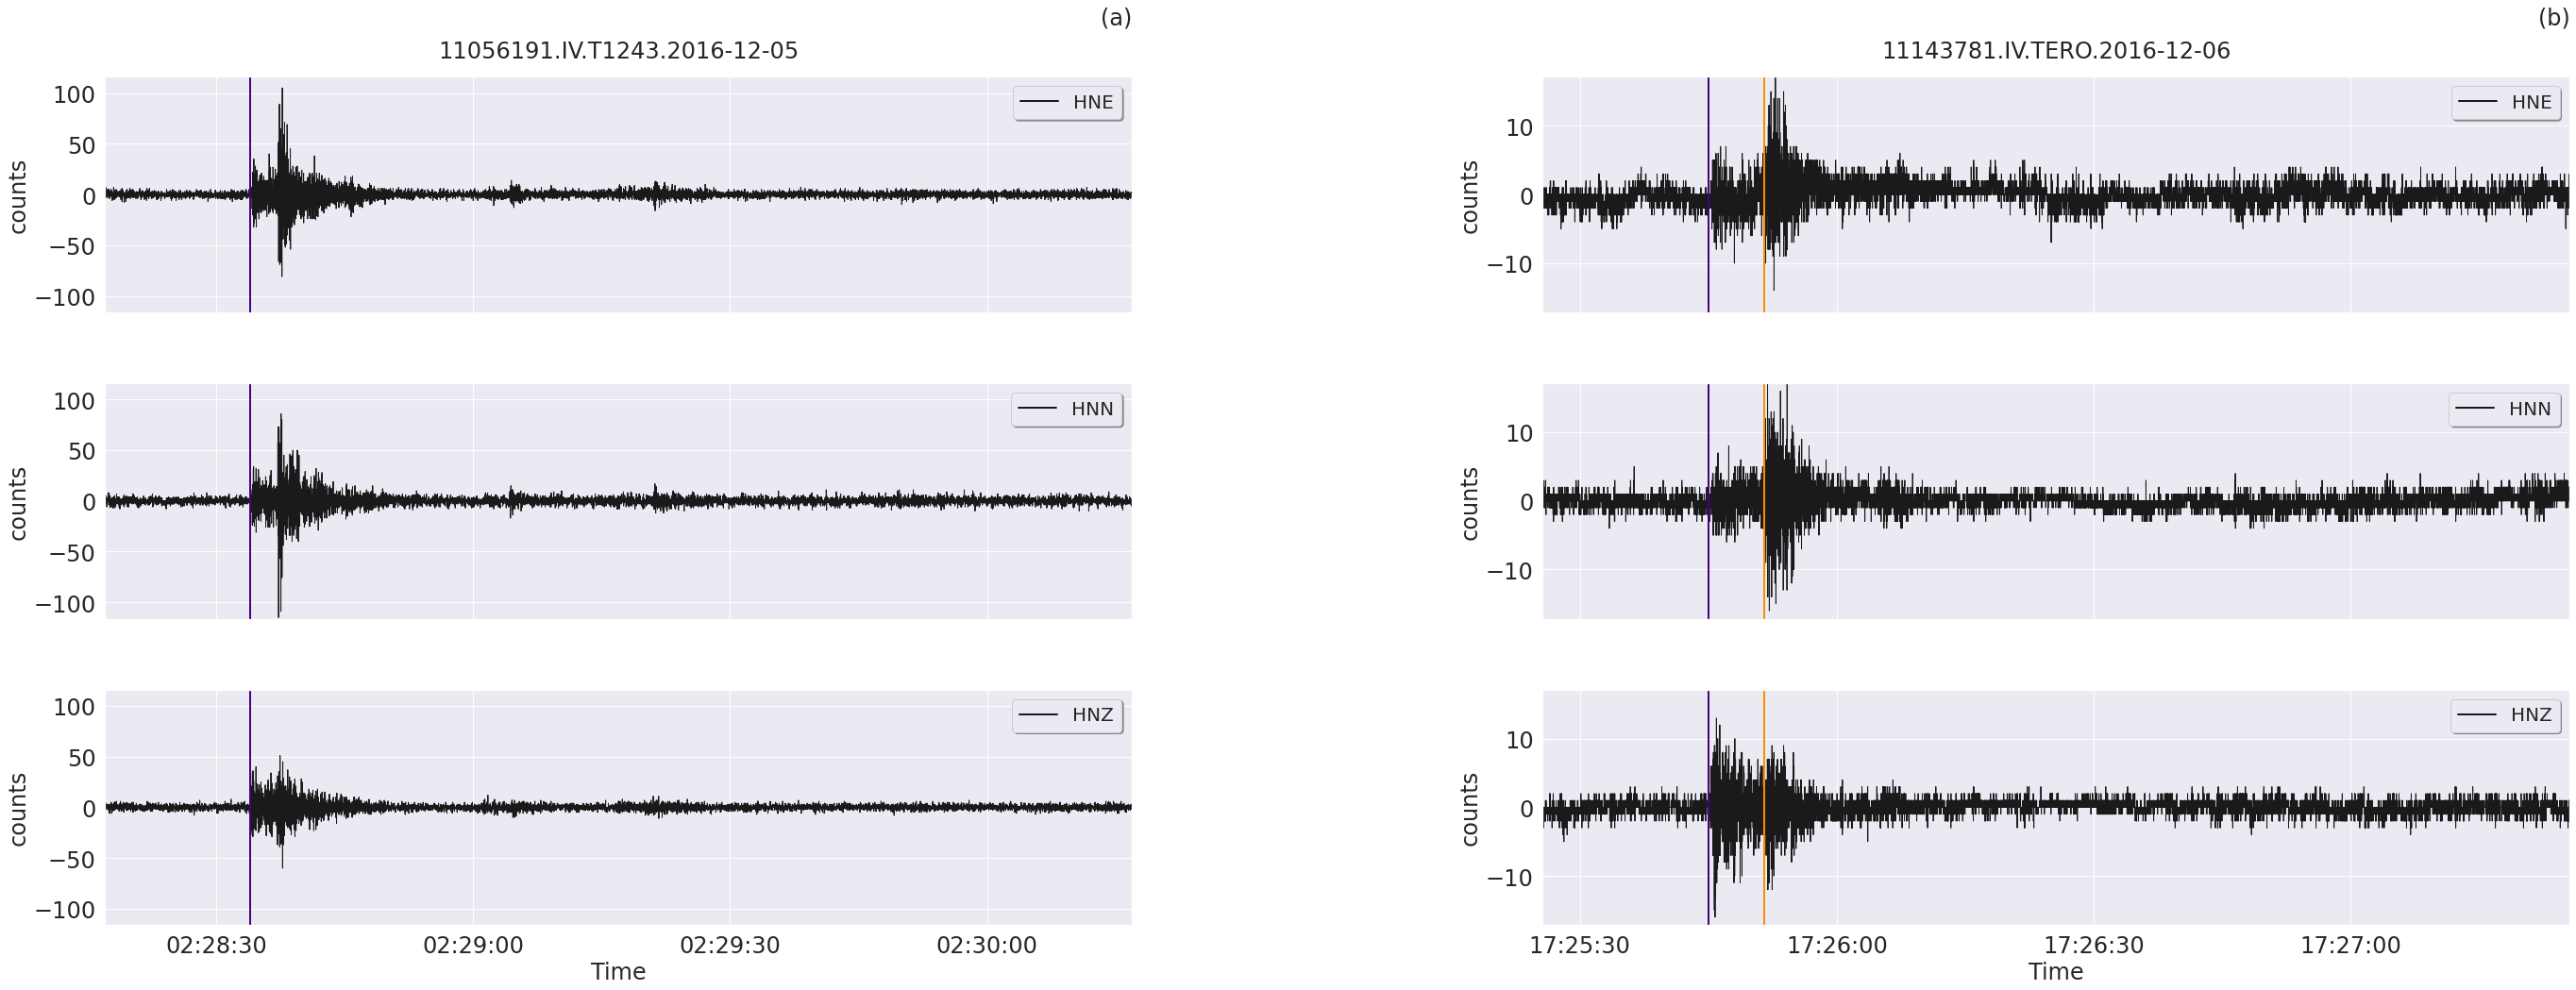

In [67]:
multiple_streams(df,h5,lines,wftype,nrow,ncol,units,labs,filt,freq_min,freq_max)

**Plot waveforms - 2 <= Magnitude < 3 (in Counts)**

In [58]:
chosen_lines = []
plots_line = 2

df_mag2to3 = events_metaData.loc[(events_metaData.source_magnitude >= 2) &
                             (events_metaData.source_magnitude < 3)]

if mag2to3 > 0:
    lista = list(df_mag2to3.sample(n=plots_line, random_state=1).index)
    chosen_lines = chosen_lines + lista
    chosen_lines    
else:
    print('')

lines = chosen_lines
# Kind of unit
units = len(lines)*["counts"]

# Do you want the traces filtered?
filt = False
freq_min=3.0
freq_max=20.0

nrow=int(len(lines)/plots_line)
ncol=plots_line

labs = alllabs[:(ncol*nrow)]

wftype='ev_c'
if wftype == 'ev_c':
    df = events_metaData
    h5 = events_h5File

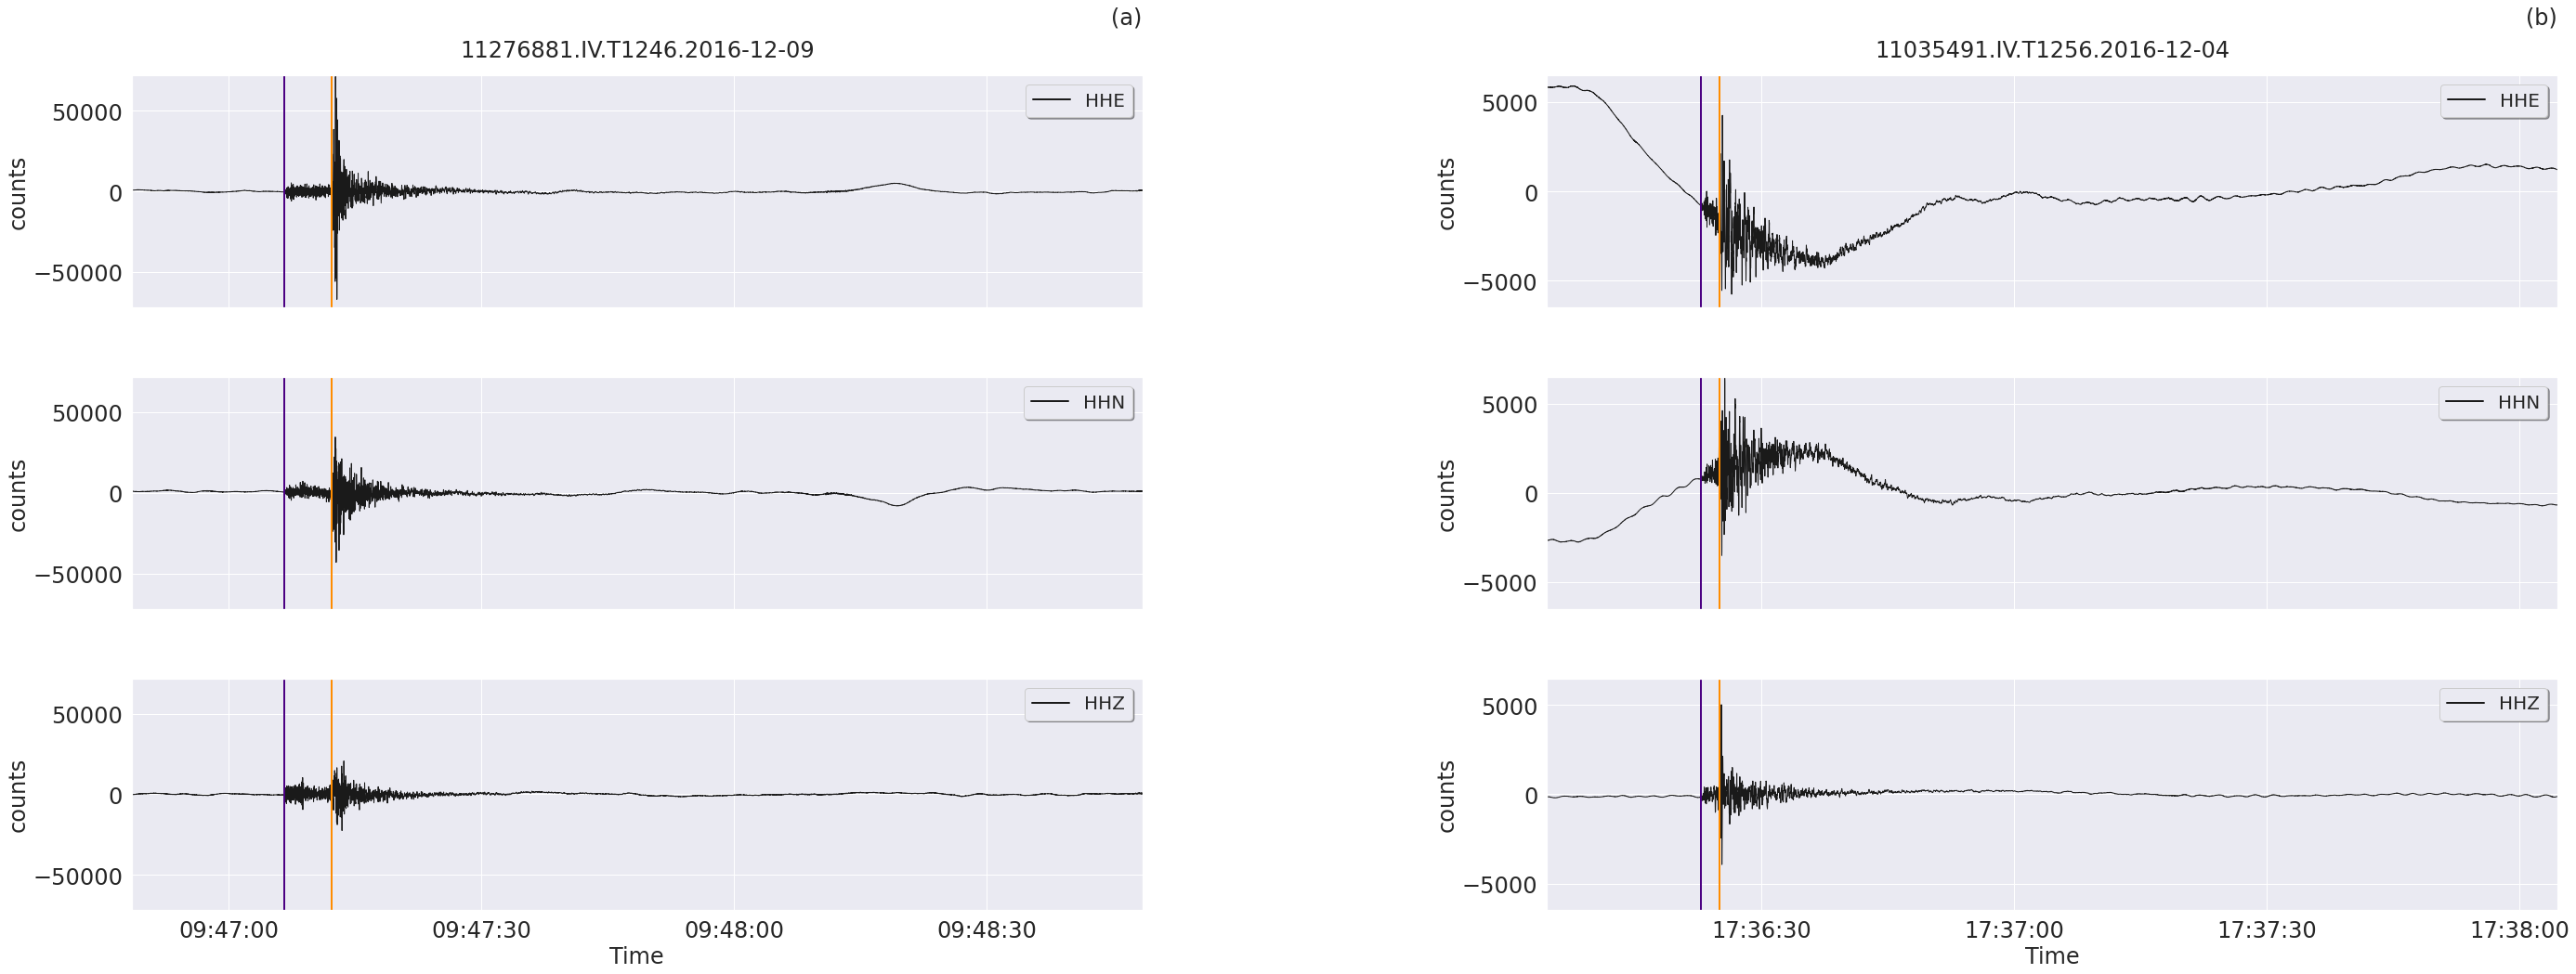

In [59]:
multiple_streams(df,h5,lines,wftype,nrow,ncol,units,labs,filt,freq_min,freq_max)

**Plot waveforms - 3 <= Magnitude < 4 (in Counts)**

In [60]:
chosen_lines = []
plots_line = 2

df_mag3to4 = events_metaData.loc[(events_metaData.source_magnitude >= 3) &
                             (events_metaData.source_magnitude < 4)]

if mag3to4 > 0:
    lista = list(df_mag3to4.sample(n=plots_line, random_state=1).index)
    chosen_lines = chosen_lines + lista
    chosen_lines    
else:
    print('')

lines = chosen_lines
# Kind of unit
units = len(lines)*["counts"]

# Do you want the traces filtered?
filt = False
freq_min=3.0
freq_max=20.0

nrow=int(len(lines)/plots_line)
ncol=plots_line

labs = alllabs[:(ncol*nrow)]

wftype='ev_c'
if wftype == 'ev_c':
    df = events_metaData
    h5 = events_h5File

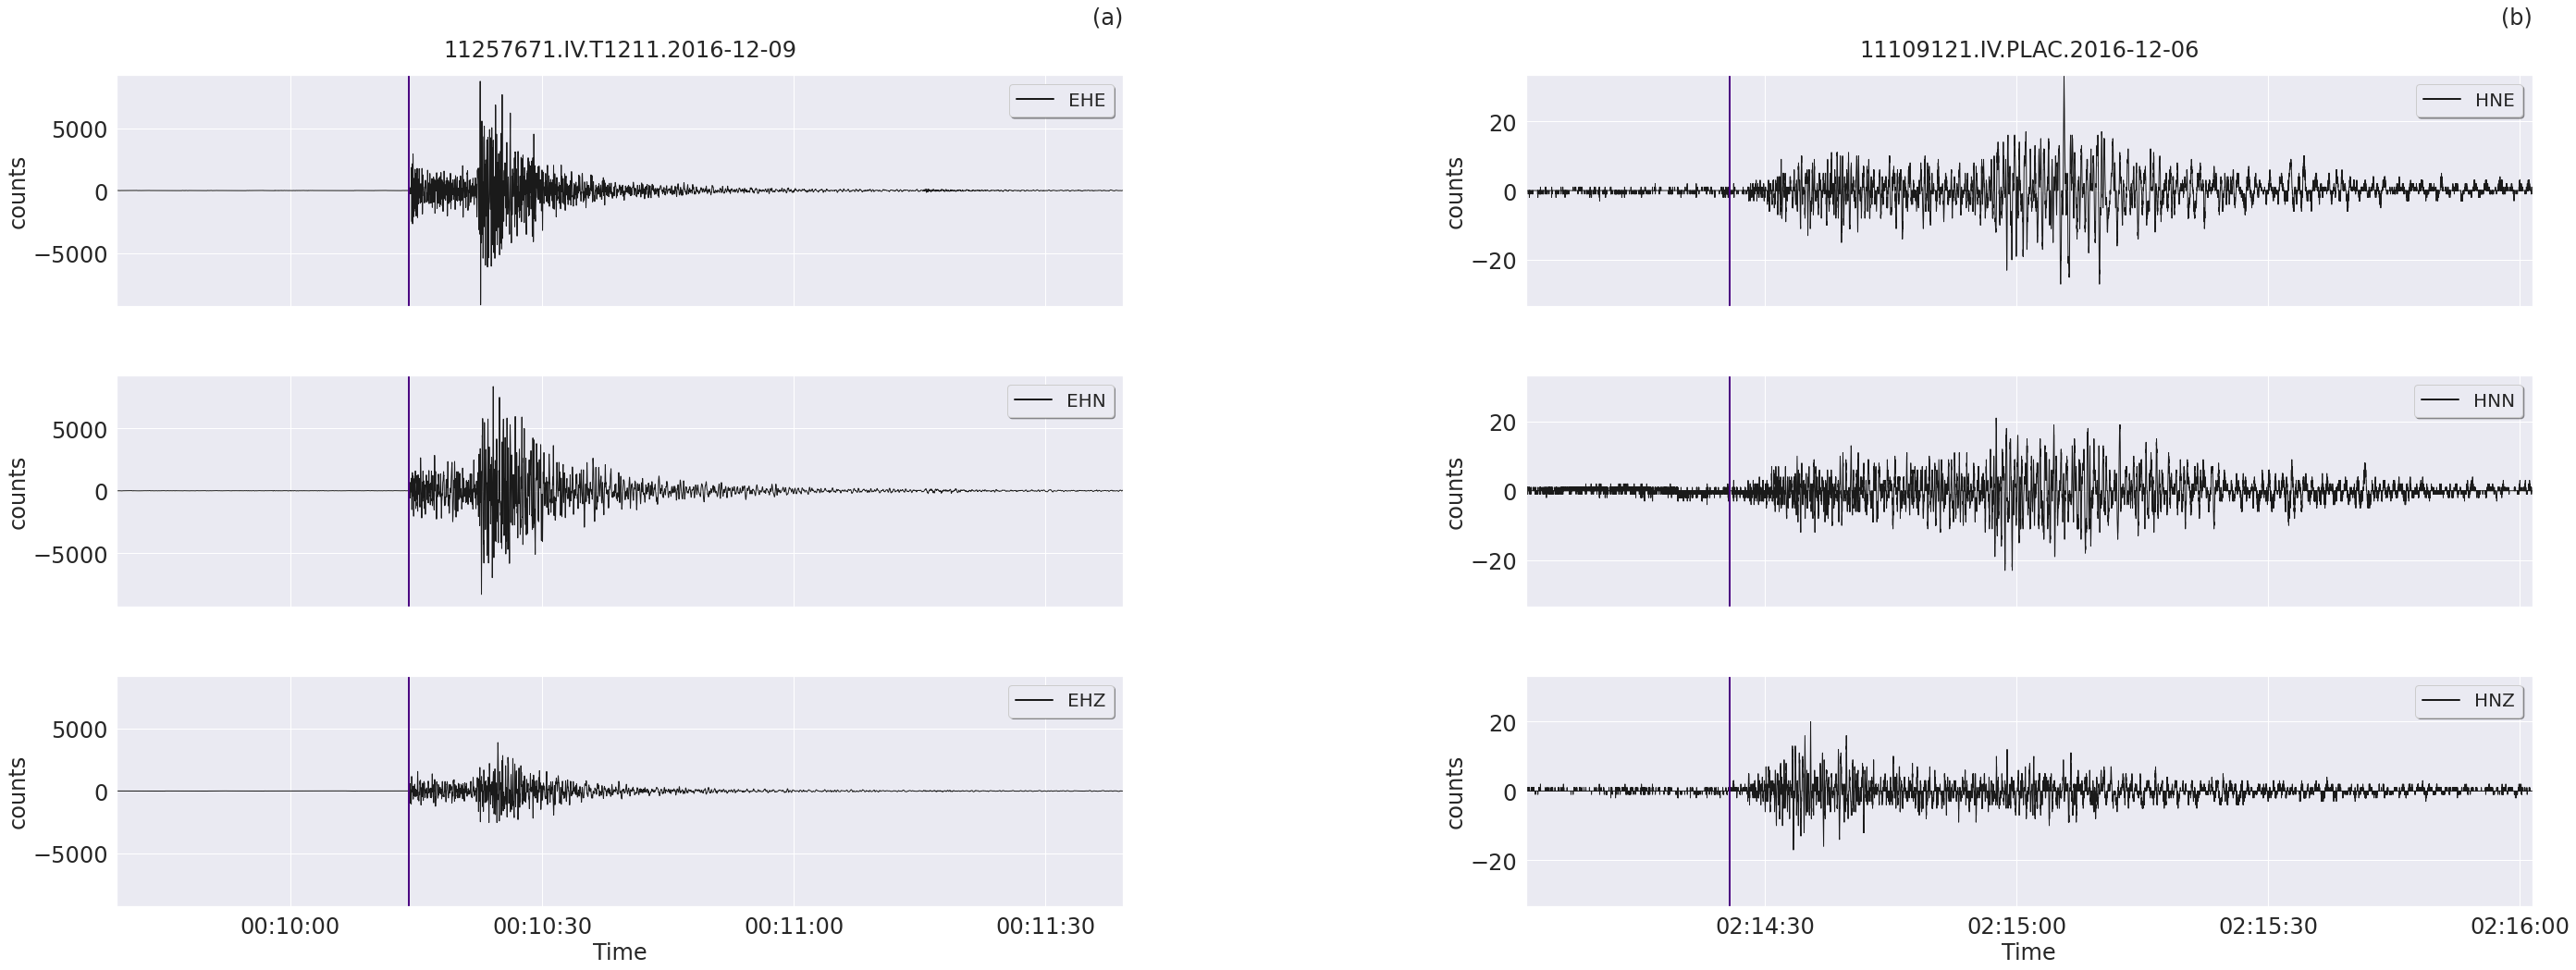

In [61]:
multiple_streams(df,h5,lines,wftype,nrow,ncol,units,labs,filt,freq_min,freq_max)

**Plot waveforms - Magnitude > 4 (in Counts)**

In [62]:
chosen_lines = []
plots_line = 2

df_magupto4 = events_metaData.loc[(events_metaData.source_magnitude >= 4)]

if magupto4 > 0:
    lista = list(df_magupto4.sample(n=plots_line, random_state=1).index)
    chosen_lines = chosen_lines + lista
    chosen_lines    
else:
    print('')

lines = chosen_lines
# Kind of unit
units = len(lines)*["counts"]

# Do you want the traces filtered?
filt = False
freq_min=3.0
freq_max=20.0

nrow=int(len(lines)/plots_line)
ncol=plots_line

labs = alllabs[:(ncol*nrow)]

wftype='ev_c'
if wftype == 'ev_c':
    df = events_metaData
    h5 = events_h5File

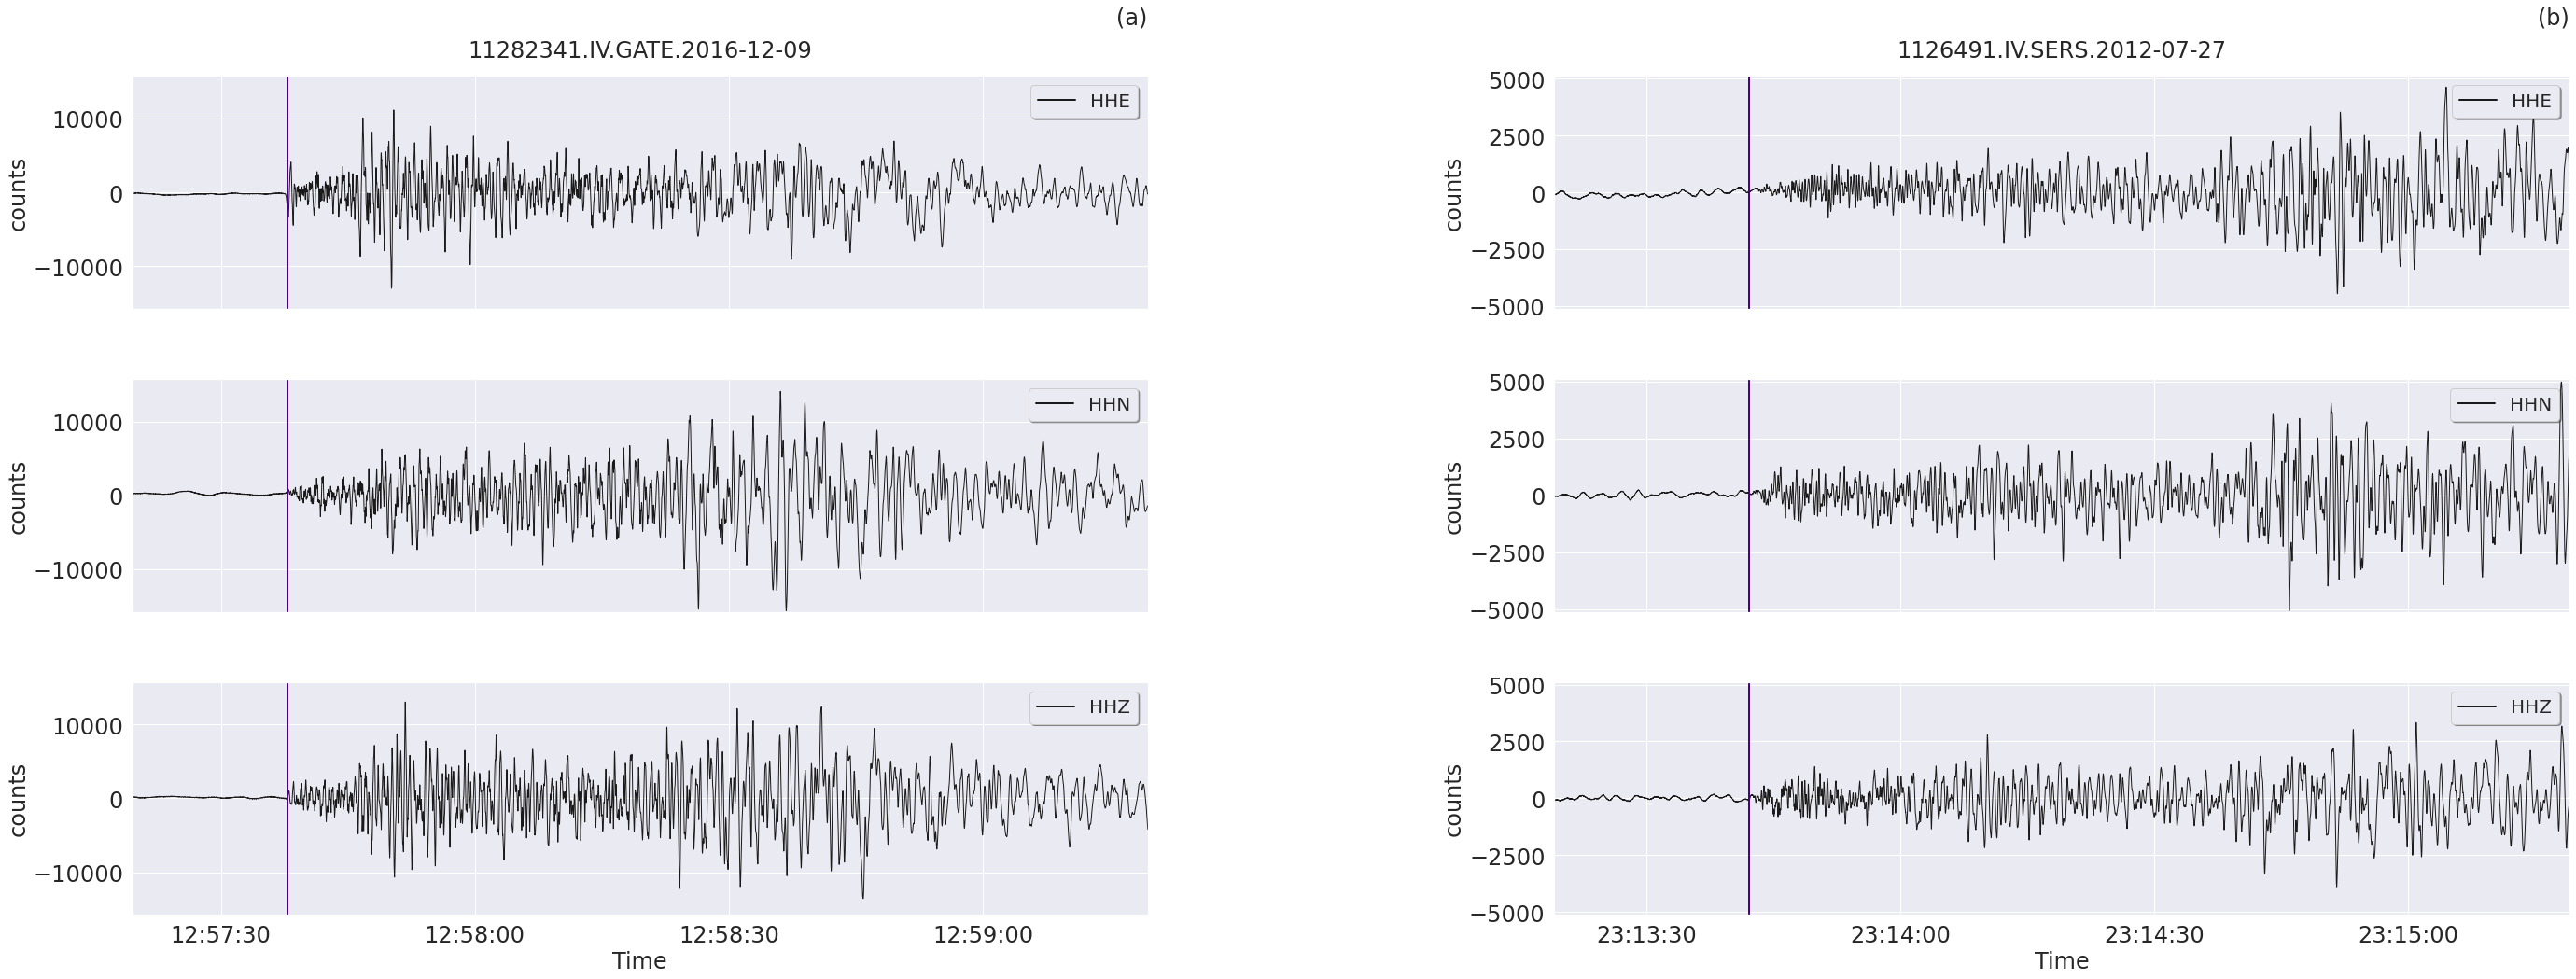

In [63]:
multiple_streams(df,h5,lines,wftype,nrow,ncol,units,labs,filt,freq_min,freq_max)